# Problem Statement



At some point or the other almost each one of us has used an Ola or Uber for taking a ride.

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.


To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

# Exploratory Data Analysis



Let's check the data files! According to the data description we should find the following columns:

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because 
the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)

trip_duration - (target) duration of the trip in seconds

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [298]:
nyc_df = pd.read_csv('nyc_taxi_trip_duration.csv') #reading file

In [299]:
nyc_df.shape 

(729322, 11)

In [300]:
nyc_df.isnull().sum() #checking is their any null values

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# DATA TYPE

In [302]:
nyc_df.dtypes 

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

-Datatype of pickup_datetime and dropup_datetime should be changed it's not correct

In [303]:
from datetime import timedelta
import datetime as dt

In [304]:
nyc_df['pickup_datetime']=pd.to_datetime(nyc_df.pickup_datetime)
nyc_df['dropoff_datetime']=pd.to_datetime(nyc_df.dropoff_datetime)

In [305]:
nyc_df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [306]:
nyc_df['store_and_fwd_flag']=nyc_df['store_and_fwd_flag'].map({'N':0,'Y':1}) #changing the values to 0 and 1

In [308]:
nyc_df['store_and_fwd_flag'].value_counts()

0    725282
1      4040
Name: store_and_fwd_flag, dtype: int64

Text(0.5, 1.0, 'store_and_fwd_flag')

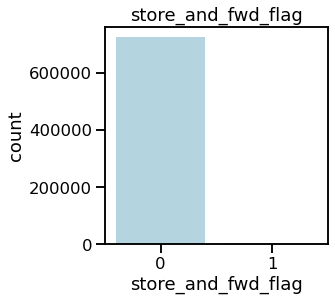

In [309]:
plt.figure(figsize=(4,4))
sns.countplot(df['store_and_fwd_flag'], color='lightblue')
plt.title("store_and_fwd_flag")

-Difference between value counts is very high in store_and_fwd_flag 

Text(0.5, 1.0, 'Vendor ID')

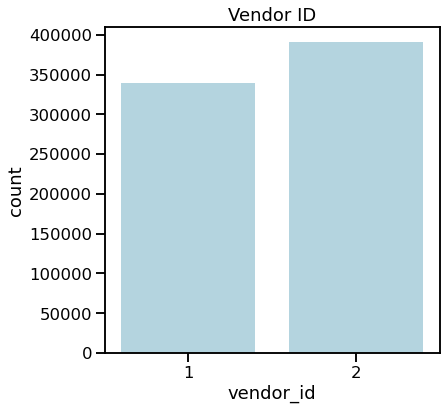

In [310]:
plt.figure(figsize=(6,6))
sns.countplot(df['vendor_id'], color='lightblue')
plt.title("Vendor ID")
#vendor_id 

Text(0.5, 1.0, 'Descriptive Stats')

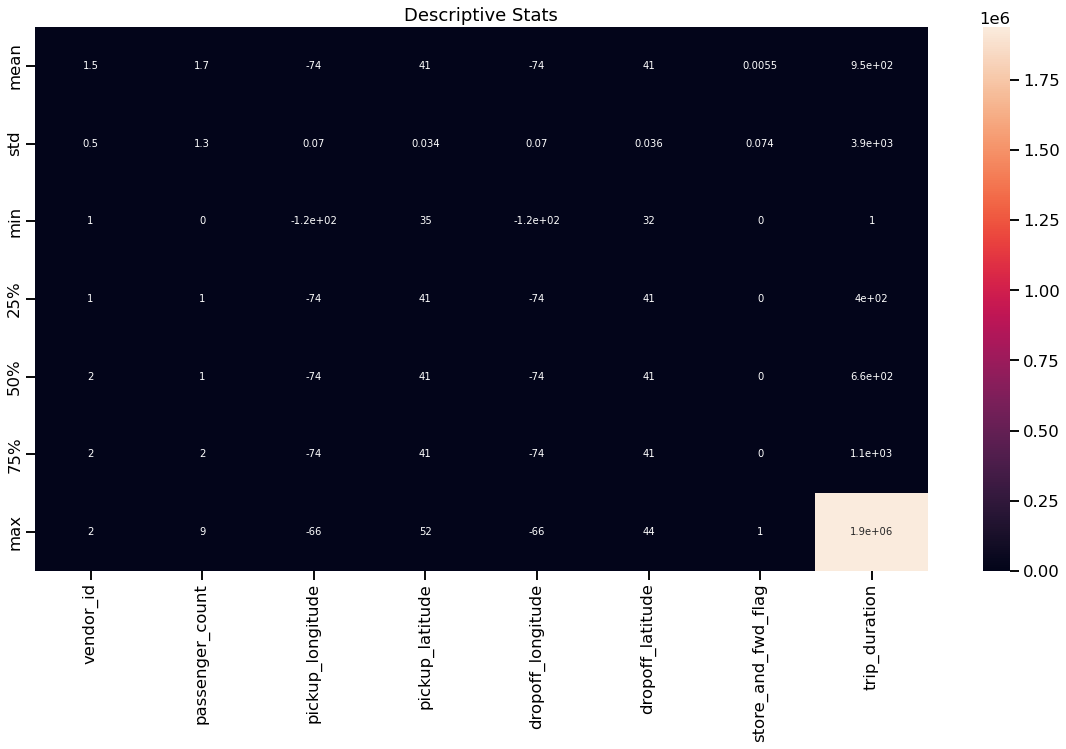

In [311]:
plt.figure(figsize=(20,10))
sns.heatmap(df.describe()[1:], annot=True)
plt.title('Descriptive Stats')


-We can observe trips having 0 passengers which can consider as false record

-Also, there are trips having trip duration upto Approx. 538 hours which is kind of impossible in a day.


-log transformation used to make high skewed distribution less skewed and make outliers smoothens.

In [312]:
nyc_df['checking_trip_duration'] =(nyc_df['dropoff_datetime']-nyc_df['pickup_datetime']).map(lambda x: x.total_seconds())
differ=nyc_df[np.abs(nyc_df['checking_trip_duration'].values-nyc_df['trip_duration'].values)>1]
differ.shape

(0, 12)

In [313]:
nyc_df['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

In [314]:
nyc_df['log_trip_duration'] = np.log(nyc_df['trip_duration'].values + 1)

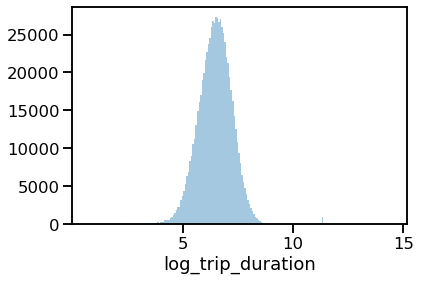

In [319]:
import seaborn as sns
sns.distplot(nyc_df['log_trip_duration'], kde=False, bins=200)

Text(0.5, 1.0, 'Passenger Count Distribution')

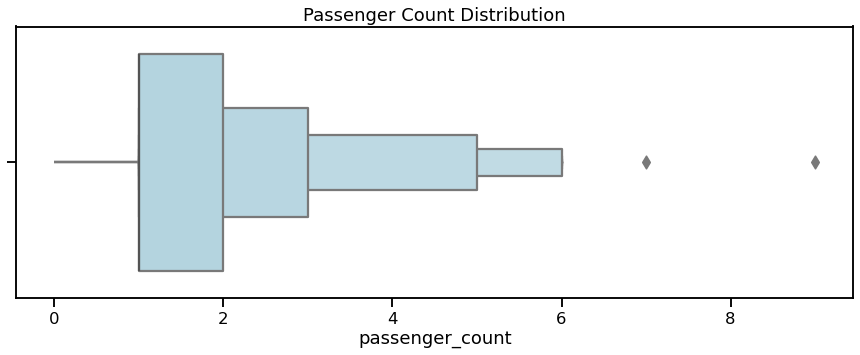

In [324]:
plt.figure(figsize=(15,5))
sns.boxenplot(nyc_df['passenger_count'], color='lightblue')
plt.title('Passenger Count Distribution')
#Spread of Passenger count

-Most number of trips are done by 1-2 passengers

-5-6 passengers means cab must be 8 seater.

In [325]:
nyc_df['passenger_count'].unique()

array([1, 2, 6, 3, 4, 5, 0, 7, 9], dtype=int64)

In [326]:
nyc_df=nyc_df.loc[nyc_df['passenger_count']!=0]

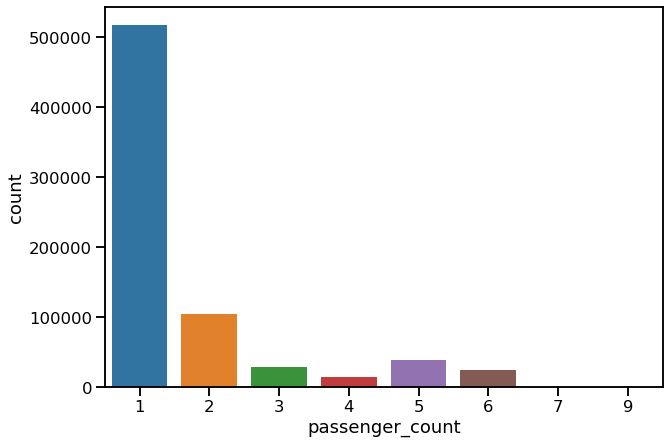

In [327]:
plt.figure(figsize=(10,7))
sns.countplot(nyc_df['passenger_count'])



-Most trips are done by single passengers.

-5 - 9 passengers trip states us that cab must be a Large vehicle.

In [329]:
nyc_df['pickup_day'] = nyc_df['pickup_datetime'].dt.day #Extracting day
nyc_df['pickup_month'] = nyc_df['pickup_datetime'].dt.month #Extracting month
nyc_df['pickup_date'] = nyc_df['pickup_datetime'].dt.date #Extracting date
nyc_df['pickup_hour'] = nyc_df['pickup_datetime'].dt.hour #Extracting hour
nyc_df['pickup_min'] = nyc_df['pickup_datetime'].dt.minute #Extracting minute
nyc_df['pickup_weekday'] = nyc_df['pickup_datetime'].dt.weekday #Extracting weekdays

nyc_df['dropoff_min'] = nyc_df['dropoff_datetime'].dt.minute #Extracting minute

Text(0.5, 1.0, 'Overall Week day Trips')

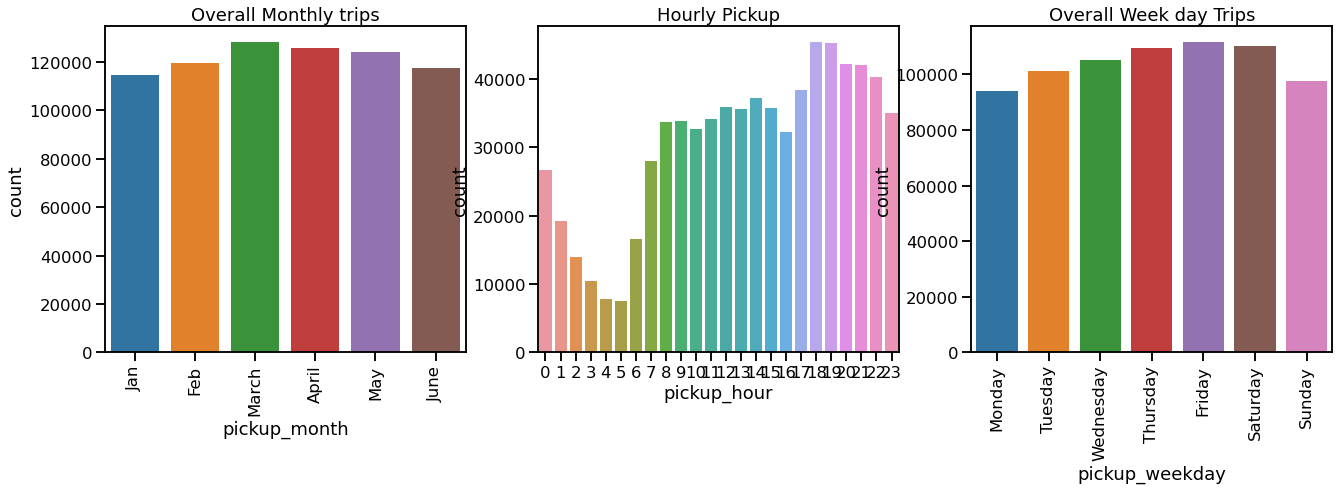

In [330]:
plt.figure(figsize=(22,6))

plt.subplot(131)
sns.countplot(nyc_df['pickup_month'])
plt.xticks([0,1,2,3,4,5], labels=['Jan','Feb','March','April','May','June'], rotation=90)
plt.ylabel('count')
plt.title('Overall Monthly trips')

plt.subplot(132)
sns.countplot(nyc_df['pickup_hour'])
plt.ylabel('count')
plt.title('Hourly Pickup')

plt.subplot(133)
sns.countplot(nyc_df['pickup_weekday'])
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=90)
plt.ylabel('count')
plt.title('Overall Week day Trips')


-We've data of 6 months.

-March and April are the highest among all six months.

-January being lowest among all months.

-5 pm to 10 pm are highly busy hours.

-Observations tells us that Fridays and Saturdays are doing great.

# Correlation Heatmap

Text(0.5, 1.0, 'Correlation Plot')

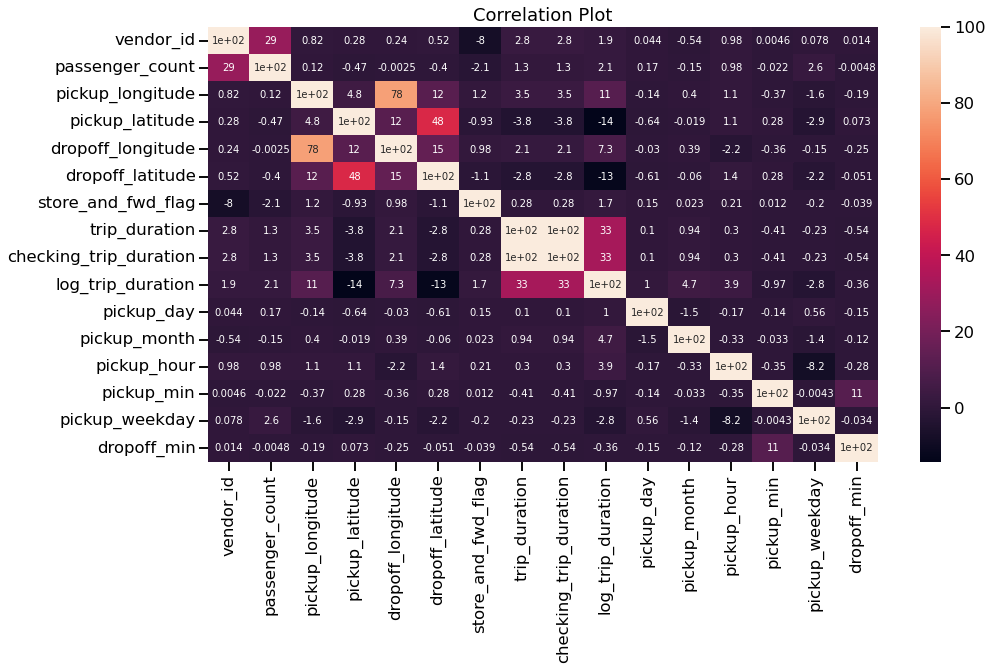

In [339]:
plt.figure(figsize=(15,8))
sns.heatmap(nyc_df.corr()*100, annot=True)
plt.title('Correlation Plot')

In [341]:
new_df= nyc_df[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag','trip_duration','pickup_day','pickup_month','pickup_hour','pickup_min','pickup_weekday','dropoff_min',]]

# Normalization

In [343]:
X= nyc_df[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag','trip_duration','pickup_day','pickup_month','pickup_hour','pickup_min','pickup_weekday','dropoff_min']]
y=nyc_df['log_trip_duration']

In [344]:
from sklearn.preprocessing import StandardScaler
col=X.columns
st=StandardScaler()

In [345]:
data=st.fit_transform(X)
data=pd.DataFrame(data, columns=col)
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,dropoff_min
0,0.931523,-0.504508,0.280918,0.832139,0.137199,0.538018,-0.074617,-0.142897,1.551516,-0.903483,0.372989,0.600149,-1.560050,0.997032
1,-1.073511,0.257439,-0.212145,-0.570853,-0.306498,-1.577466,-0.074617,0.038230,-0.517504,-0.308479,1.466275,0.311674,0.486557,1.341461
2,0.931523,0.257439,-0.341208,-0.877002,0.364912,0.642183,-0.074617,0.176662,0.631951,-0.903483,0.529173,1.696357,1.509860,-0.208468
3,0.931523,3.305228,0.169793,0.261971,0.239160,0.800654,-0.074617,0.048838,-1.207178,-1.498488,-0.720297,0.830930,-1.048398,-1.528778
4,-1.073511,-0.504508,-0.625145,-1.263662,-0.212101,-0.309276,-0.074617,-0.026976,0.172169,-0.903483,-1.188848,0.715540,-0.536746,1.513675


In [346]:
X=data

# PCA

-Applying PCA

In [347]:
from sklearn.decomposition import PCA

In [348]:
rat=PCA(n_components=len(new_df.columns)-1)
rat.fit_transform(X)
exp = rat.explained_variance_ratio_

In [349]:
exp

array([0.13556577, 0.09873017, 0.09336135, 0.07967543, 0.07723775,
       0.07257572, 0.07097379, 0.07051851, 0.06991164, 0.06534039,
       0.06322392, 0.05040923, 0.03712737])

-Cumulative Variance Ratio

Text(0.5, 1.0, 'Elbow Plot')

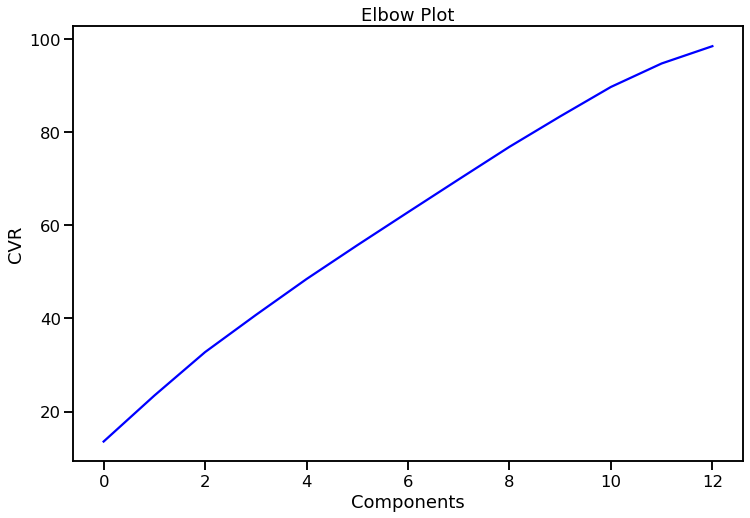

In [358]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(exp)*100, color="b")
plt.xlabel("Components")
plt.ylabel("CVR")#Cumulative Variance Ratio
plt.title('Elbow Plot')

In [360]:
rat = PCA(n_components=12) #consider 12 as requried components
data_transform = rat.fit_transform(X)
rat.explained_variance_
#Applying PCA as per required components

array([1.89792332, 1.38222433, 1.30706066, 1.11545755, 1.08133002,
       1.01606152, 0.99363439, 0.98726051, 0.97876434, 0.91476667,
       0.88513612, 0.70573016])

In [361]:
X=data_transform
y=np.log(new_df['trip_duration']).values

In [367]:
#Importing train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error , mean_squared_error , mean_absolute_error

In [368]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=10)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((510502, 12), (218787, 12), (510502,), (218787,))

# BENCHMARK MODEL

In [369]:
null = np.zeros_like(test_y, dtype=float)
null.fill(test_y.mean())
print ("Null RMSLE : ", np.sqrt(mean_squared_log_error(test_y, null)))

Null RMSLE :  0.11449766694084991


-Here I calculated Null RMSLE, which I will set as a benchmark for my Model's RMSLE.

-It is a benchmark against which I can measure my regression model. Null RMSLE can be achieved by predicting the mean response value. 

# LINEAR REGRESSION

In [370]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(train_X, train_y)
LR_pred = LR.predict(test_X)
LR_pred

array([6.59912894, 6.28296127, 6.47781583, ..., 6.35046121, 6.31947194,
       6.47555758])

In [372]:
train_liner=LR.predict(train_X)
LR_train=mean_absolute_error(train_liner, train_y)
print('Training Score: ', LR_train)

Training Score:  0.5596097452615353


In [374]:
test_linear=LR.predict(test_X)
LR_test=mean_absolute_error(test_linear, test_y)
print('Testing Score: ', LR_test)

Testing Score:  0.5590272465644682


<Figure size 720x720 with 0 Axes>

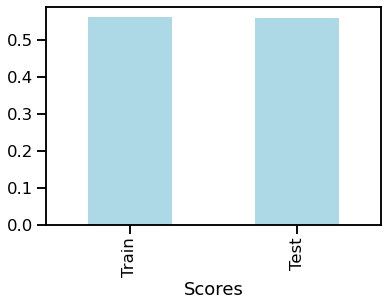

In [375]:
plt.figure(figsize=(10,10))
g=pd.DataFrame({'MAE': np.array([mean_absolute_error(train_liner,train_y), mean_absolute_error(test_linear, test_y)]), 'Scores':np.array(['Train', 'Test'])})
g.set_index('Scores').plot(kind='bar', color='lightblue', legend=False)

In [376]:
residuals = pd.DataFrame({
    'fitted values ' : y_test,
    'predicted values ': test_predict,
})

residuals['residuals'] = residuals['fitted values '] - residuals['predicted values ']
residuals.head()

,fitted values,predicted values,residuals
0,6.727432,6.953497,-0.226066
1,5.690359,5.912493,-0.222134
2,5.407172,5.604928,-0.197756
3,7.063048,6.929582,0.133466
4,6.510258,6.502015,0.008243


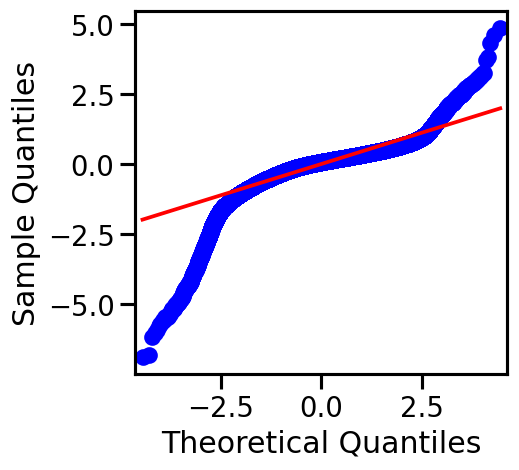

In [377]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(figsize=(4,4), dpi=120)
qqplot(residuals.residuals, line = 's', ax=ax)
plt.show()

In [378]:
#Checking scores

print (f"Training Score:  {LR.score(train_X, train_y)}")

print (f"Testing Score :  {LR.score(test_X, test_y)}")

Training Score:  0.13207051418369808
Testing Score :  0.16557510963308963


In [379]:
print (f"Cross Validation Score :   {cross_val_score(LR, train_X, train_y, cv=5).mean()}")

print (f"R2_Score :  {r2_score(LR_pred, test_y)}")

Cross Validation Score :   -0.0003263055846998375
R2_Score :  -8.168052319418928


In [380]:
#coeficients & intercept

LR.intercept_, LR.coef_

(6.463860546345349,
 array([-0.00181117, -0.1524069 ,  0.01957622,  0.01908389,  0.07637489,
         0.05015792,  0.14049275,  0.04673839,  0.11290244, -0.01097444,
         0.00511569,  0.00976087]))

# Regularized RIDGE Model and coefficients.

In [381]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=.3)
ridge.fit(train_X,train_y)
print ("Ridge model:", (ridge.coef_))

Ridge model: [-0.00181117 -0.15240684  0.01957621  0.01908388  0.07637485  0.05015789
  0.14049268  0.04673836  0.11290238 -0.01097443  0.00511569  0.00976086]


In [382]:
print(ridge.score(train_X, train_y))
print(ridge.score(test_X, test_y))

0.13207051418366877
0.16557507417821882


# Regularized LASSO Model and coefficients

In [383]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(train_X,train_y)
print ("Lasso model:", (lasso.coef_))

Lasso model: [-0.         -0.08361919  0.          0.          0.          0.
  0.05504555  0.          0.02730765 -0.          0.          0.        ]


In [384]:
print(lasso.score(train_X, train_y))
print(lasso.score(test_X, test_y))

0.07434848762676416
0.0763228249611797


# KNN 

In [413]:
from sklearn import neighbors
from math import sqrt

In [414]:
rmse_val = [] #to store rmse values for different k
for i in range(20):
    i= i+1
    model = neighbors.KNeighborsRegressor(n_neighbors = i)

    model.fit(train_X, train_y)  #fit the model
    pred=model.predict(test_X) #make prediction on test set
    err = sqrt(mean_squared_error(test_y,pred)) 
    rmse_val.append(err) #store rmse values
    print('for k= ' , i, ':', err)

for k=  1 : 0.5498057011064441
for k=  2 : 0.48394036541981666
for k=  3 : 0.4629584247806899
for k=  4 : 0.4533035314192885
for k=  5 : 0.4488523083916653
for k=  6 : 0.44638317435414804
for k=  7 : 0.44499751662754683
for k=  8 : 0.4444496880686357
for k=  9 : 0.44431481613594737
for k=  10 : 0.4446174401471468
for k=  11 : 0.4453292406832391
for k=  12 : 0.4459361712761462
for k=  13 : 0.44650465257216615
for k=  14 : 0.4471324908602828
for k=  15 : 0.4479291984679949
for k=  16 : 0.4488187794234927
for k=  17 : 0.44953847455332024
for k=  18 : 0.4506500098722462
for k=  19 : 0.451488872385147
for k=  20 : 0.45250612422106823


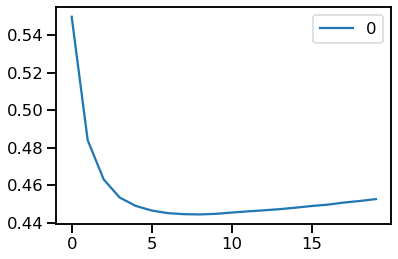

In [415]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

-KNN model taking to much time to process as the data is large

-We can notice the curve at 5 so we can consider that as k

-As per task value of K is found

In [416]:
# Creating instance of KNN
reg = neighbors.KNeighborsRegressor(n_neighbors = 5)

# Fitting the model
reg.fit(train_X, train_y)

# Predicting over the Train Set 
test_predict = reg.predict(test_X)
k = mean_absolute_error(test_predict, test_y)
print('Test MAE    ', k )

Test MAE     0.2994739224543158


# Decision Tree

In [387]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(max_depth=10)
DT.fit(train_X, train_y)
DT_pred = DT.predict(test_X)

In [388]:
train_decision=DT.predict(train_X)
DT_train=mean_absolute_error(train_decision, train_y)
print('Training Score: ', DT_train)

Training Score:  0.05700407448721575


In [389]:
test_decision=DT.predict(test_X)
DT_test=mean_absolute_error(test_decision, test_y)
print("Testing Score: ", DT_test)

Testing Score:  0.05987039121872861


<Figure size 720x720 with 0 Axes>

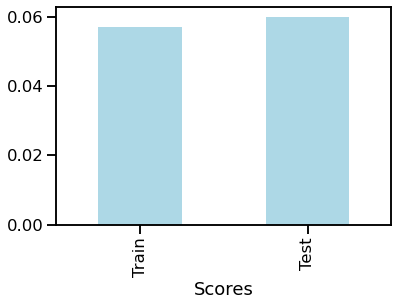

In [391]:
plt.figure(figsize=(10,10))
g1=pd.DataFrame({'MAE':np.array([mean_absolute_error(train_decision,train_y), mean_absolute_error(test_decision,test_y)]), 'Scores':(['Train', 'Test'])})
g1.set_index('Scores').plot(kind='bar', color='lightblue', legend=False)

In [392]:
print (f"Training Score:  {DT.score(train_X, train_y)}")

print (f"Testing Score :  {DT.score(test_X, test_y)}")

Training Score:  0.950859002878186
Testing Score :  0.938391940548724


In [393]:
print (f"Cross Validation Score :  {cross_val_score(DT, train_X, train_y, cv=5).mean()}")

print (f"R2_Score :  {r2_score(DT_pred, test_y)}")

Cross Validation Score :  0.9398256217156558
R2_Score :  0.9352014580189422


In [394]:
a= np.sqrt(mean_squared_log_error(DT_pred, test_y))
print (f"RMSLE: {a}")

RMSLE: 0.03436405971923967


# RANDOM FOREST

In [398]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=5, max_depth=10)
RF.fit(train_X, train_y)
RF_pred = RF.predict(test_X)
RF_pred

array([6.72484539, 5.70510833, 5.48616174, ..., 6.39560957, 6.29157096,
       5.70513796])

In [399]:
train_random=RF.predict(train_X)
random_train=mean_absolute_error(train_random, train_y)
print('Training Score: ', random_train)

Training Score:  0.056607925562739386


In [400]:
test_random=RF.predict(test_X)
random_test=mean_absolute_error(test_random, test_y)
print("Testing Score: ", random_test)

Testing Score:  0.05886271561279912


<Figure size 720x720 with 0 Axes>

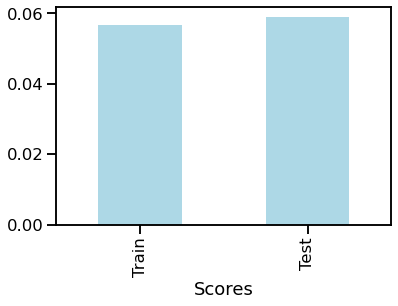

In [401]:
plt.figure(figsize=(10,10))
g2=pd.DataFrame({'MAE':np.array([mean_absolute_error(train_random,train_y), mean_absolute_error(test_random,test_y)]), 'Scores':(['Train', 'Test'])})
g2.set_index('Scores').plot(kind='bar', color='lightblue', legend=False)

In [402]:
print (f"Training Score:   {RF.score(train_X, train_y)}")

print (f"Testing Score :   {RF.score(test_X, test_y)}")

Training Score:   0.9542391529512017
Testing Score :   0.9460185914672311


In [403]:
print (f"Cross Validation Score :  {cross_val_score(RF, train_X, train_y, cv=5).mean()}")

print (f"R2_Score :  {r2_score(RF_pred, test_y)}")

Cross Validation Score :  0.9440218102810152
R2_Score :  0.942692786861649


In [404]:
print (f"RMSLE : {np.sqrt(mean_squared_log_error(RF_pred, test_y))}")

RMSLE : 0.03264083016219814


# Training and Testing Scores 

Text(0.5, 1.0, 'Lower the value of MAE, better a model fits.')

<Figure size 864x720 with 0 Axes>

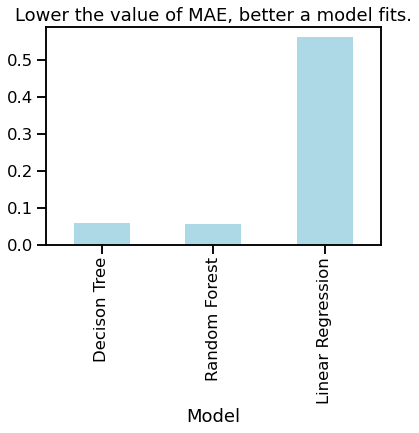

In [411]:
plt.figure(figsize=(12,10)) #train scores of model
train_score = pd.DataFrame({'MAE':np.array([mean_absolute_error(train_decision, train_y), mean_absolute_error(train_random, train_y), mean_absolute_error(train_liner, train_y)]), 'Model':np.array(['Decison Tree', 'Random Forest', 'Linear Regression'])})
train_score.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("Lower the value of MAE, better a model fits.")

Text(0.5, 1.0, 'Lower the value of MAE, better a model fits.')

<Figure size 864x720 with 0 Axes>

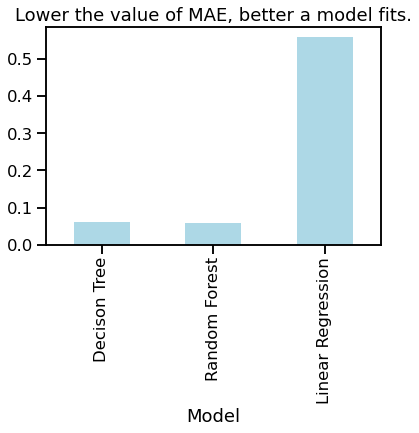

In [412]:
plt.figure(figsize=(12,10)) #test score of model
test_score = pd.DataFrame({'MAE':np.array([mean_absolute_error(test_decision, test_y), mean_absolute_error(test_random, test_y), mean_absolute_error(test_linear, test_y)]), 'Model':np.array(['Decison Tree', 'Random Forest', 'Linear Regression'])})
test_score.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("Lower the value of MAE, better a model fits.")

-A metric that tells us the mean absolute difference between the predicted values and the actual values in a dataset. The lower the MAE, the better a model fits a dataset.

-Decision Tree and Random Forest preforming well compare to linear regression.

# R2 Scores Evaluation


Text(0.5, 1.0, 'R2 Scores')

<Figure size 864x720 with 0 Axes>

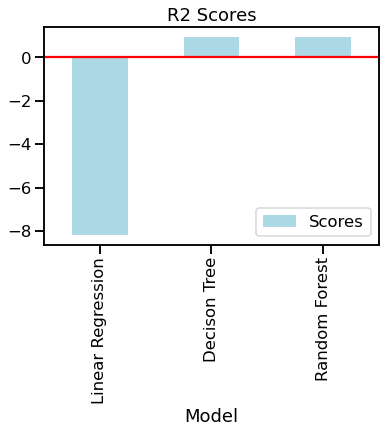

In [408]:
plt.figure(figsize=(12,10))
r_score = pd.DataFrame({'Scores':np.array([r2_score(LR_pred, test_y), r2_score(DT_pred, test_y), r2_score(RF_pred, test_y)]), 'Model':np.array(['Linear Regression', 'Decison Tree', 'Random Forest'])})
r_score.set_index('Model').plot(kind="bar", color="lightblue")
plt.axhline(y=0, color='r')
plt.title("R2 Scores")




-1.0 can be considered best possible score and it can be negative because the model can be arbitrarily worse

-We're getting good fit score for Decision Tree and Random Forest , i.e, close to 1.0

# RMSLE Evaluation

-RMSLE (Root Mean Squared Logarithmic Error)

-It is a ratio between true value and predicted value




-RMSLE indicate better fit with lesser LOSS if it has lower values

Text(0.5, 1.0, 'RMSLE - Lesser is Better')

<Figure size 864x720 with 0 Axes>

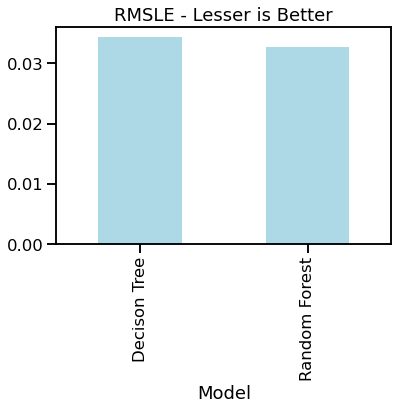

In [409]:
plt.figure(figsize=(12,10))
rmlse = pd.DataFrame({'RMSLE':np.array([np.sqrt(mean_squared_log_error(DT_pred, test_y)), np.sqrt(mean_squared_log_error(RF_pred, test_y))]), 'Model':np.array(['Decison Tree', 'Random Forest'])})
rmlse.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("RMSLE - Lesser is Better")

-We have NULL RMSLE : 0.1146 as a benchmark to beat.

-Random Forest is providing us reduced RMSLE compare to Decision Tree.